# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [67]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from matplotlib import pyplot as plt

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np

#print(np.__version__) #print numpy version, e.g., 1.21.5
#to upgrade: pip install --upgrade numpy

import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Import data

Read the data from the CSV file and display some values to see if the reading is good.
I used ";" as a separator when reading from the file in order to read correctly the data.

In [9]:
import pandas as pd

data = pd.read_csv("MergeConflictsDataset.csv", sep=";")

data = data.ffill()
data.head()

,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


Print the data about the columns to get a better understanding of the data.

In [10]:
data.columns

Index(['commit', 'parent1', 'parent2', 'ancestor', 'is pr', 'added lines',
       'deleted lines', 'devs parent1', 'devs parent2', 'time', 'nr files',
       'added files', 'deleted files', 'renamed files', 'copied files',
       'modified files', 'nr commits1', 'nr commits2', 'density1', 'density2',
       'fix', 'bug', 'feature', 'improve', 'document', 'refactor', 'update',
       'add', 'remove', 'use', 'delete', 'change', 'messages_min',
       'messages_max', 'messages_mean', 'messages_median', 'conflict'],
      dtype='object')

Use a simple data.fix in order to detect mixed data types and fix it

In [11]:
data.fix

0        0
1        1
2        0
3        1
4        1
        ..
26968    0
26969    1
26970    1
26971    1
26972    0
Name: fix, Length: 26973, dtype: int64

Get some info about the dataset

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26973 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

Check the number of bugs and how often it is to encounter one in the code commited

In [13]:
data["bug"].value_counts()

bug
0     22525
1      2331
2       784
3       387
4       253
5       163
6       103
7        90
9        51
8        51
11       38
10       36
12       31
13       29
14       23
15       13
16       11
21        9
17        8
19        6
20        6
18        4
22        3
53        2
26        2
27        2
52        1
37        1
25        1
30        1
45        1
40        1
24        1
55        1
42        1
43        1
89        1
73        1
Name: count, dtype: int64

Describe the dataset to get a better understanding of the data stored in it

In [14]:
data.describe()

,is pr,added lines,deleted lines,devs parent1,devs parent2,time,nr files,added files,deleted files,renamed files,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
count,26973.000000,2.697300e+04,2.697300e+04,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,...,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000,26973.000000
mean,0.777741,4.255746e+02,2.504278e+02,4.656175,1.911801,240.714159,0.752048,2.431061,1.396545,0.970229,...,4.316205,0.955437,1.338857,0.096281,1.007860,51.391280,104.662551,69.455646,68.021095,0.054425
std,0.415772,8.887706e+03,1.027916e+04,12.230444,6.534316,908.382038,10.620490,67.840678,90.614277,64.245155,...,12.924317,3.203307,4.269666,0.541916,6.033535,34.560112,89.471017,40.057823,39.385369,0.226858
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000e+00,1.000000e+00,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,47.000000,41.000000,40.000000,0.000000
50%,1.000000,1.100000e+01,2.000000e+00,1.000000,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,46.000000,88.000000,66.391304,65.000000,0.000000
75%,1.000000,7.500000e+01,1.500000e+01,3.000000,1.000000,139.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1.000000,0.000000,0.000000,67.000000,131.000000,91.714286,90.000000,0.000000
max,1.000000,1.140945e+06,1.140456e+06,158.000000,182.000000,21513.000000,1152.000000,10404.000000,10396.000000,10398.000000,...,176.000000,48.000000,78.000000,16.000000,312.000000,1326.000000,1326.000000,1326.000000,1326.000000,1.000000


In [15]:
data_list = data.columns[data.isnull().any()].tolist()
print(data_list)

[]


In [16]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [17]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [18]:
train_set, test_set = split_train_test(data, 0.2)
print(len(train_set), "train +", len(test_set), "test")

21579 train + 5394 test


In [43]:
train_set.head()

,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
21189,97b99e45175f4d95ff024a0a54e1efee85334d90,e7807c4f2d4854a879eb77eb80ce8366746f4652,af213241ab47a27fdb611c9fff1db7d4b857218f,e7807c4f2d4854a879eb77eb80ce8366746f4652,1,1,1,0,1,1,...,0,0,0,0,0,8,8,8.000000,8.0,0
25076,b6cd856b08e3860e59cc126be86b901ccab4f193,ff7368eb6b40c75b44b0abc6e6a2bf792f4afc6b,a1c34bd286d57625b844703705a39e40737a21ba,d7a4c3252ed5e630b7fb6e4b4616daddfe574fc5,1,1,1,4,1,49,...,1,0,0,1,1,83,137,106.071429,105.5,0
23271,d0904ded84bcae2fdbac1ef3eccdde63bceda555,aac4c01786e9bed0f29f24e49a72a1c7472b79d6,30eb5c7342cd8edeef7bfdb6ba3458d023524074,232eb9f8e66fc9047a6187de4c17f37ba6409e2f,1,1,0,19,1,207,...,19,2,6,1,6,65,422,133.030864,120.5,0
3658,8714710170dae03824416bf5aa8a19e14190c723,4b5c370701e8e58b123b2940b4c5eb6d36e11b1b,de2a01eee4d8e31e1245eb265831731926f08c64,7882a33e07882d3c78cbeb14cb151145521a2245,0,1,1,31,1,0,...,21,15,19,0,3,12,125,40.507653,36.0,0
257,27fdb171e2e00663cf1d0617f82f34c02289e693,642411cdc62dde62b7e9bfbc583a3cd3624e9633,09294c46a7bee4caf681cc3281f2a04085c9b72e,3c6be1aa1e0e9c6f0b3c0675bd458d4075974463,0,19,6,1,9,213,...,0,0,1,0,0,15,81,42.741935,49.0,0


We check how often it is to encounter a conflict in the train dataset:
20416 - we do not encounter a conflict
1163 - we encounter conflict

In [20]:
x = train_set[train_set.columns.drop('conflict')]
y = train_set['conflict']
y.value_counts()

conflict
0    20416
1     1163
Name: count, dtype: int64

We start dropping some collums that are not relevant, such as parent1, parent2, commit and ancestor, because they are just id fields and do not convey relevant data, just indication of the id.

In [21]:
data.drop(columns=['commit', 'parent1', 'parent2', 'ancestor'], inplace=True)

When doing the correlation matrix I realized that the collumn and line coresponding to the "copied files" is white, meaning that it has no correlation to the rest of the data. This is why I decided to drop it from my dataset.

In [22]:
data.drop(columns=['copied files'], inplace=True)

I merged the parents, density and commits into new fields developers_merged, density_merged and nr_commits_merged and dropped the initial collums.

In [23]:
data['developers_merged'] = (data['devs parent1'] + data['devs parent2'])
data.drop(columns=['devs parent1'], inplace = True)
data.drop(columns=['devs parent2'], inplace = True)

In [24]:
data['density_merged'] = (data['density1'] + data['density2'])/2
data.drop(columns=['density1'], inplace = True)
data.drop(columns=['density2'], inplace = True)

In [25]:
data['nr commits merged'] = (data['nr commits1'] + data['nr commits2'])
data.drop(columns=['nr commits1'], inplace = True)
data.drop(columns=['nr commits2'], inplace = True)

Check the number of added lines and their frequency

In [26]:
data["added lines"].value_counts()

added lines
1        5155
2        1971
0        1366
3        1125
4         898
         ... 
3121        1
5300        1
6562        1
4902        1
31486       1
Name: count, Length: 1831, dtype: int64

To get a more relevant histogram I deleted entries form the dataset that have more than 6000 lines for better visualisation. Also I check if there are added lines with minus sign, which souldn't happen and remove them as well.

In [27]:
data = data.drop(data[data['added lines'] > 6000].index)

In [28]:
data = data.drop(data[data['added lines'] < 0].index)

In [29]:
data["added lines"].value_counts()

added lines
1       5155
2       1971
0       1366
3       1125
4        898
        ... 
3816       1
3456       1
1509       1
958        1
919        1
Name: count, Length: 1588, dtype: int64

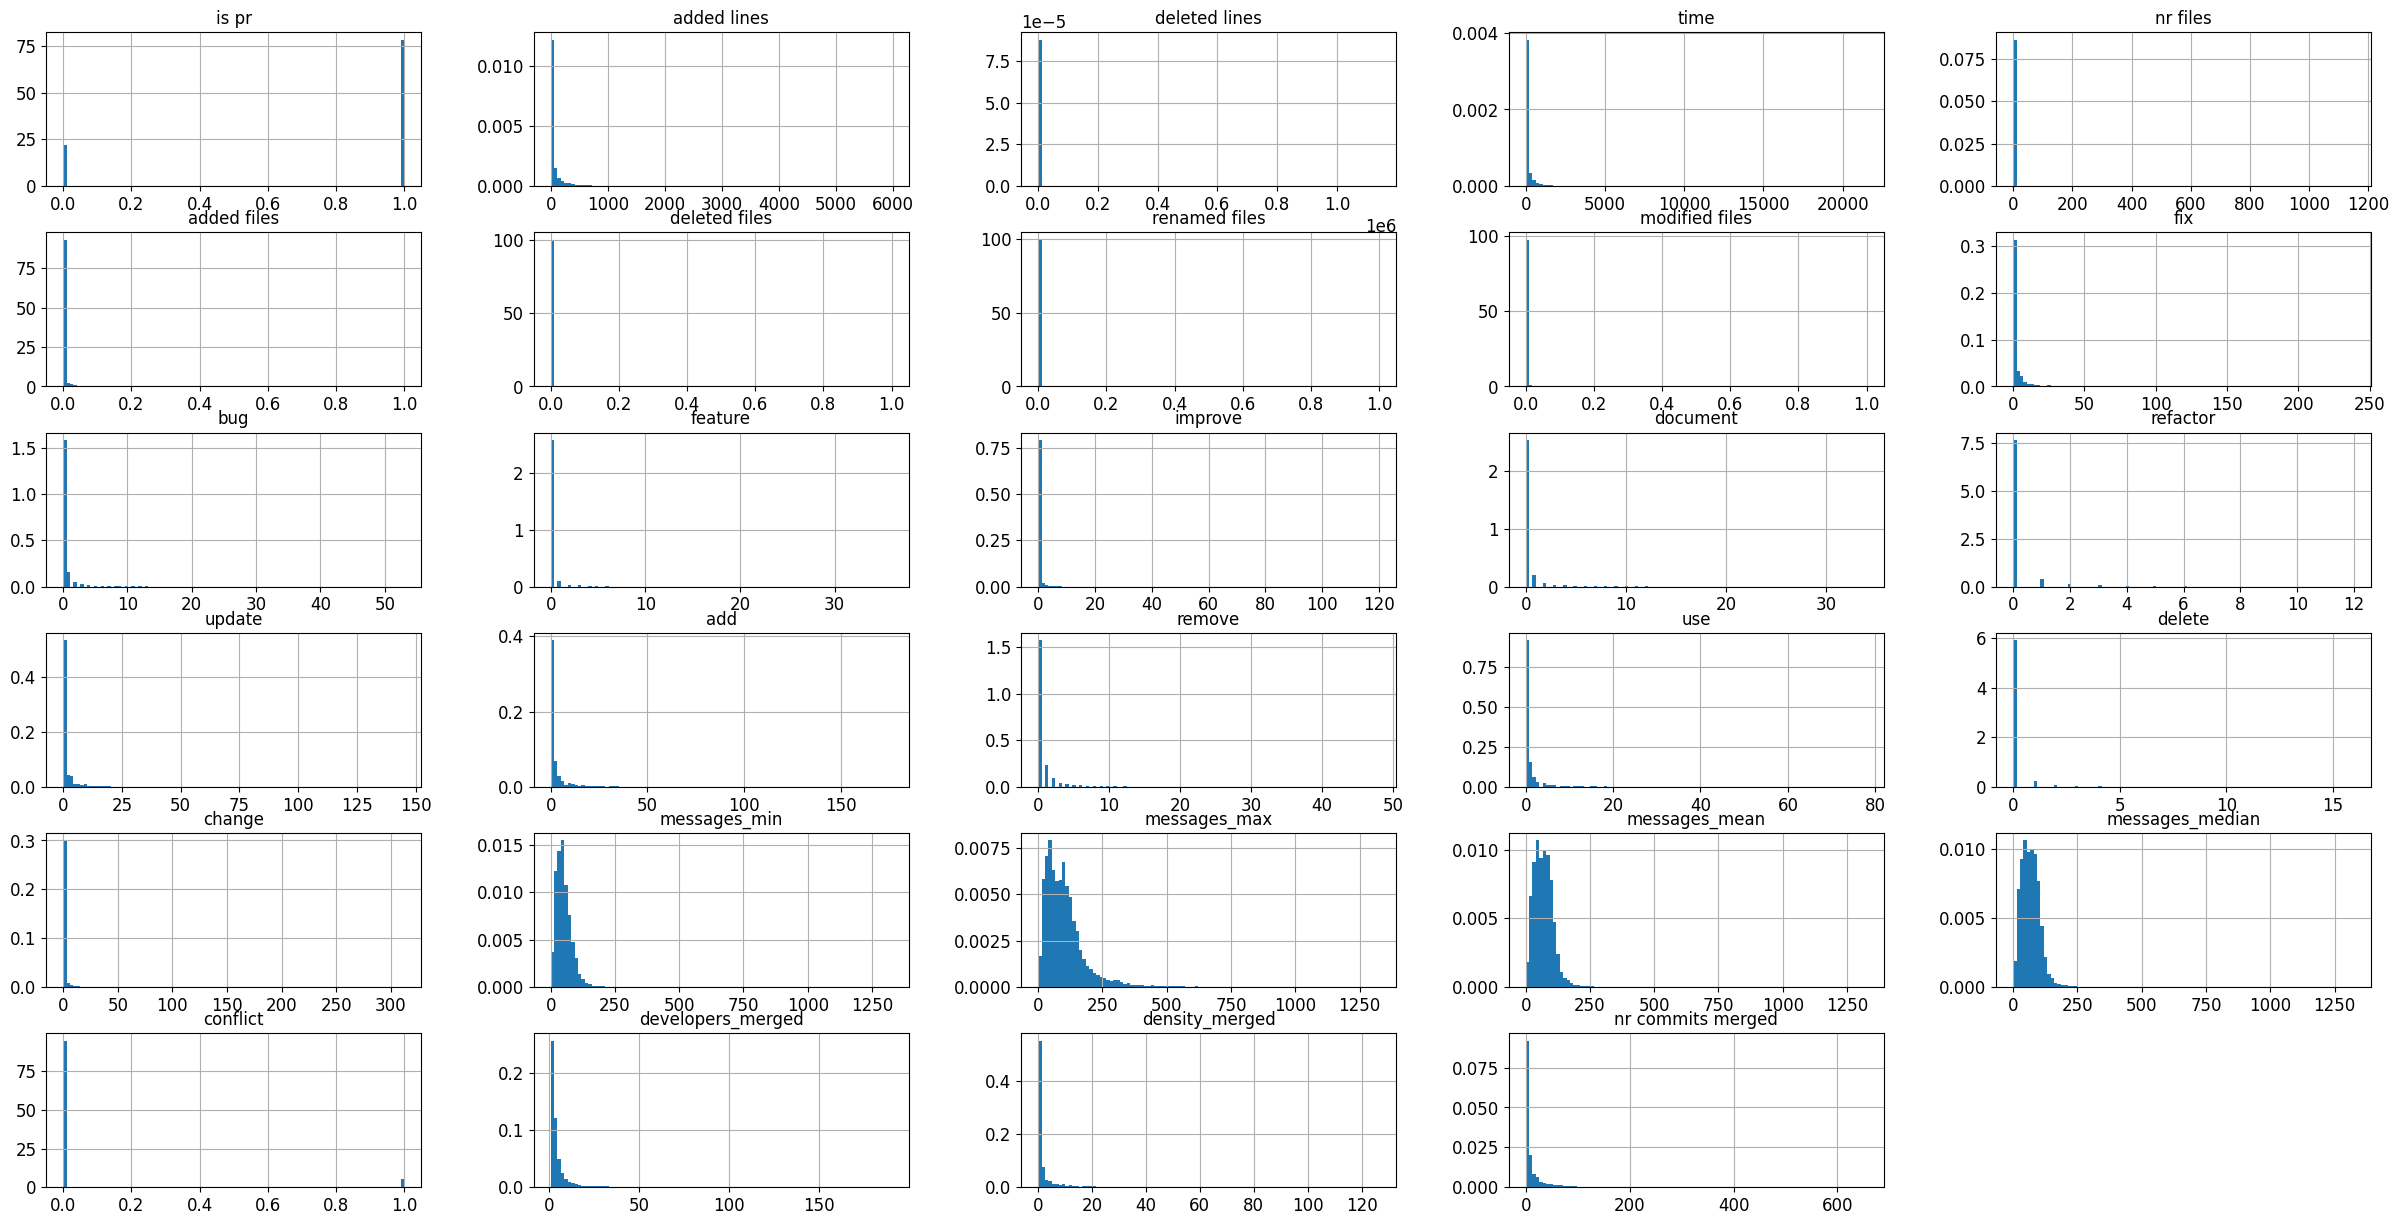

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Select the columns to be scaled
columns_to_scale = ['added files', 'deleted files', 'renamed files', 'modified files']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the selected columns
data_scaled = data.copy()  # Make a copy of the original data
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

data_scaled.hist(bins=100, figsize=(30,15), density=True)
plt.show()

Display the correlation Matrix

                      is pr  added lines  deleted lines      time  nr files  \
is pr              1.000000    -0.142030      -0.011411 -0.056994 -0.081224   
added lines       -0.142030     1.000000       0.045118  0.070979  0.039597   
deleted lines     -0.011411     0.045118       1.000000  0.001557  0.007477   
time              -0.056994     0.070979       0.001557  1.000000  0.021099   
nr files          -0.081224     0.039597       0.007477  0.021099  1.000000   
added files       -0.072868     0.583050       0.017955  0.062111  0.012330   
deleted files     -0.008093     0.031116       0.992866  0.002279  0.006308   
renamed files     -0.026850     0.116740       0.008217  0.006608  0.005611   
modified files    -0.095899     0.395108       0.022406  0.030108  0.042076   
fix               -0.103895     0.094910       0.001379  0.256893  0.097214   
bug               -0.079053     0.104132       0.000854  0.170732  0.077261   
feature           -0.066839     0.038131       0.024

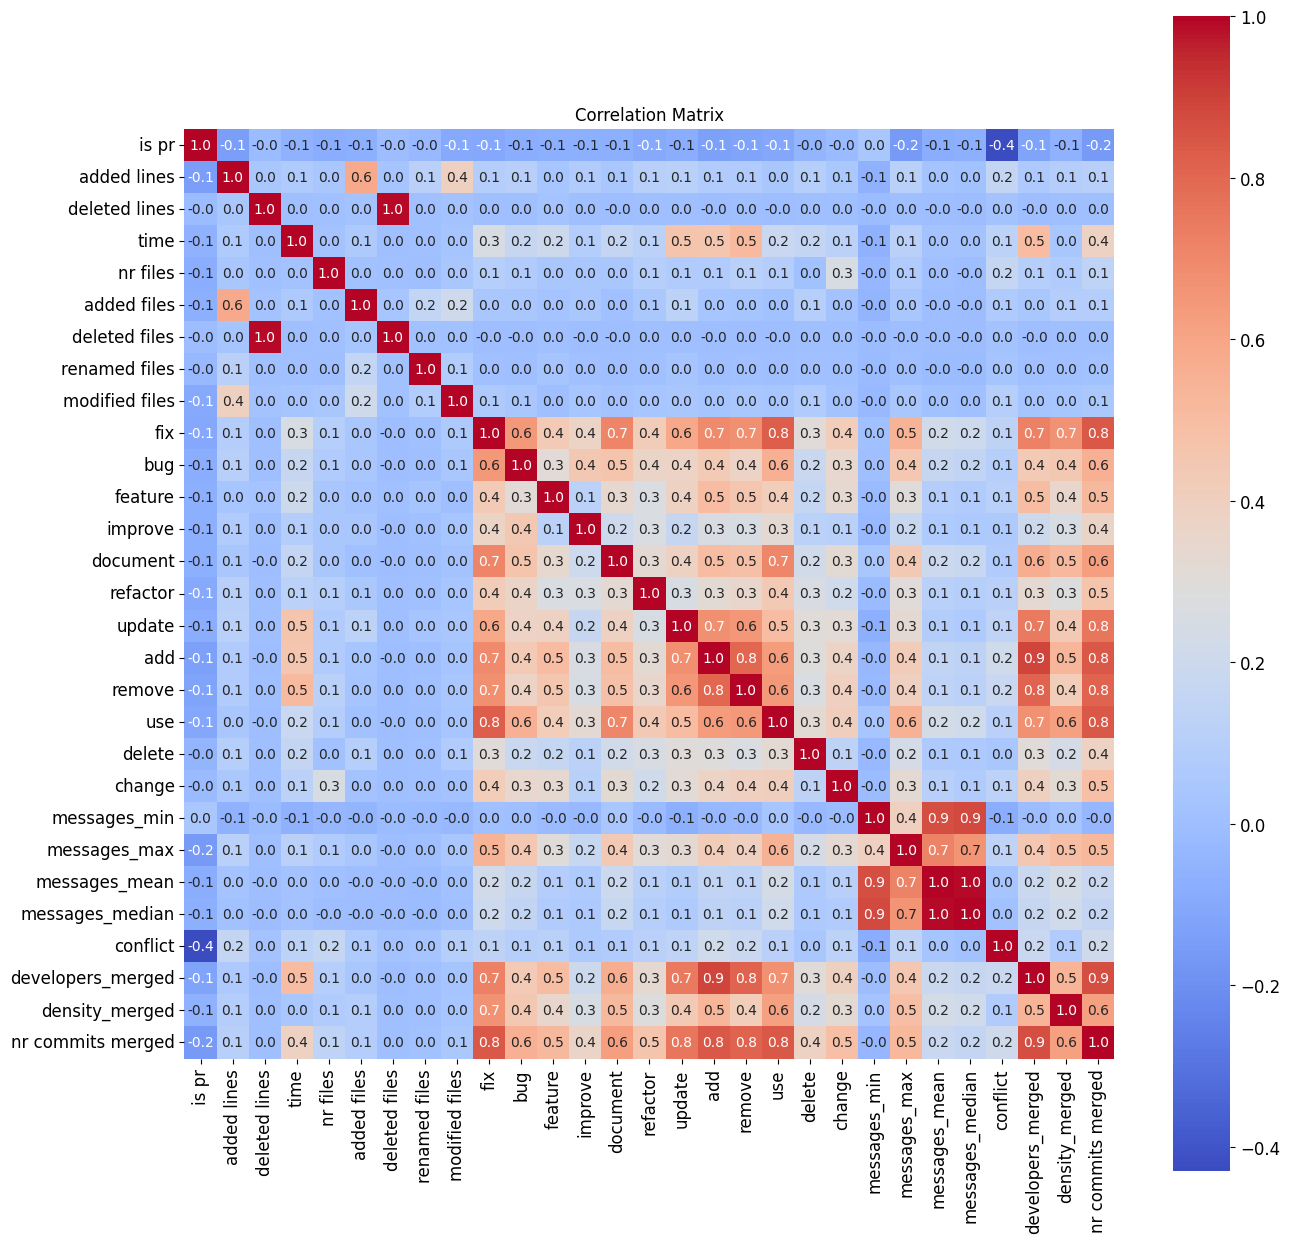

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
corr_matrix = data.corr()

# Display the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

I used a scatter diagram to see the correlation between fileds of messages type

array([[<Axes: xlabel='messages_min', ylabel='messages_min'>,
        <Axes: xlabel='messages_max', ylabel='messages_min'>,
        <Axes: xlabel='messages_mean', ylabel='messages_min'>,
        <Axes: xlabel='messages_median', ylabel='messages_min'>],
       [<Axes: xlabel='messages_min', ylabel='messages_max'>,
        <Axes: xlabel='messages_max', ylabel='messages_max'>,
        <Axes: xlabel='messages_mean', ylabel='messages_max'>,
        <Axes: xlabel='messages_median', ylabel='messages_max'>],
       [<Axes: xlabel='messages_min', ylabel='messages_mean'>,
        <Axes: xlabel='messages_max', ylabel='messages_mean'>,
        <Axes: xlabel='messages_mean', ylabel='messages_mean'>,
        <Axes: xlabel='messages_median', ylabel='messages_mean'>],
       [<Axes: xlabel='messages_min', ylabel='messages_median'>,
        <Axes: xlabel='messages_max', ylabel='messages_median'>,
        <Axes: xlabel='messages_mean', ylabel='messages_median'>,
        <Axes: xlabel='messages_median', 

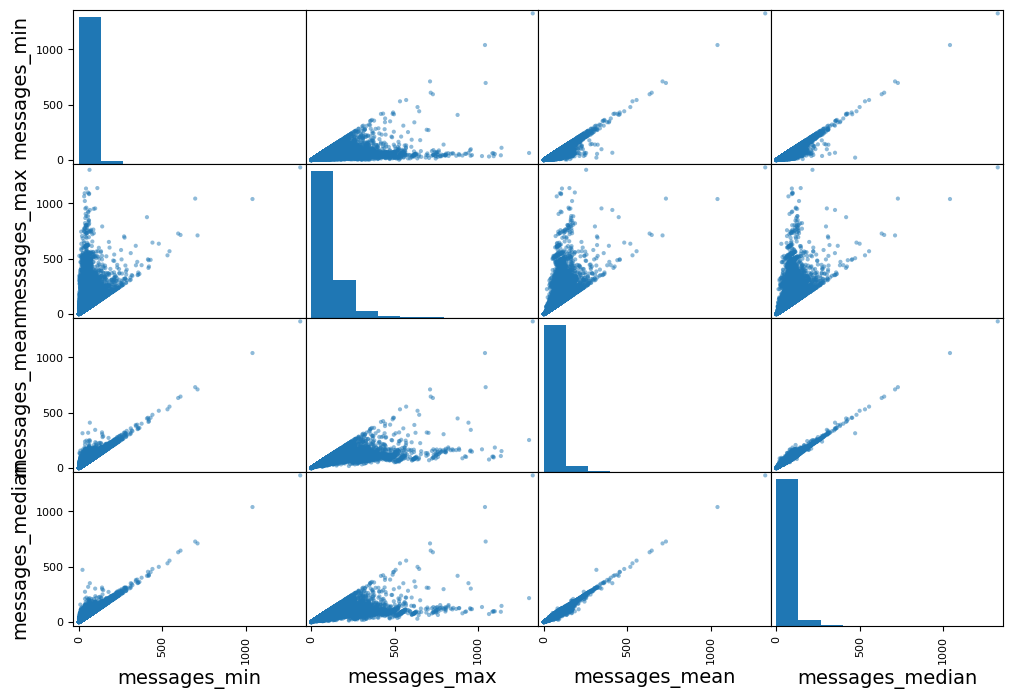

In [32]:
from pandas.plotting import scatter_matrix

attributes = ["messages_min", "messages_max", "messages_mean",
              "messages_median"]
scatter_matrix(data[attributes], figsize=(12, 8))

I used a scatter diagram to see the correlation between fileds of density type

array([[<Axes: xlabel='developers_merged', ylabel='developers_merged'>,
        <Axes: xlabel='density_merged', ylabel='developers_merged'>,
        <Axes: xlabel='nr commits merged', ylabel='developers_merged'>],
       [<Axes: xlabel='developers_merged', ylabel='density_merged'>,
        <Axes: xlabel='density_merged', ylabel='density_merged'>,
        <Axes: xlabel='nr commits merged', ylabel='density_merged'>],
       [<Axes: xlabel='developers_merged', ylabel='nr commits merged'>,
        <Axes: xlabel='density_merged', ylabel='nr commits merged'>,
        <Axes: xlabel='nr commits merged', ylabel='nr commits merged'>]],
      dtype=object)

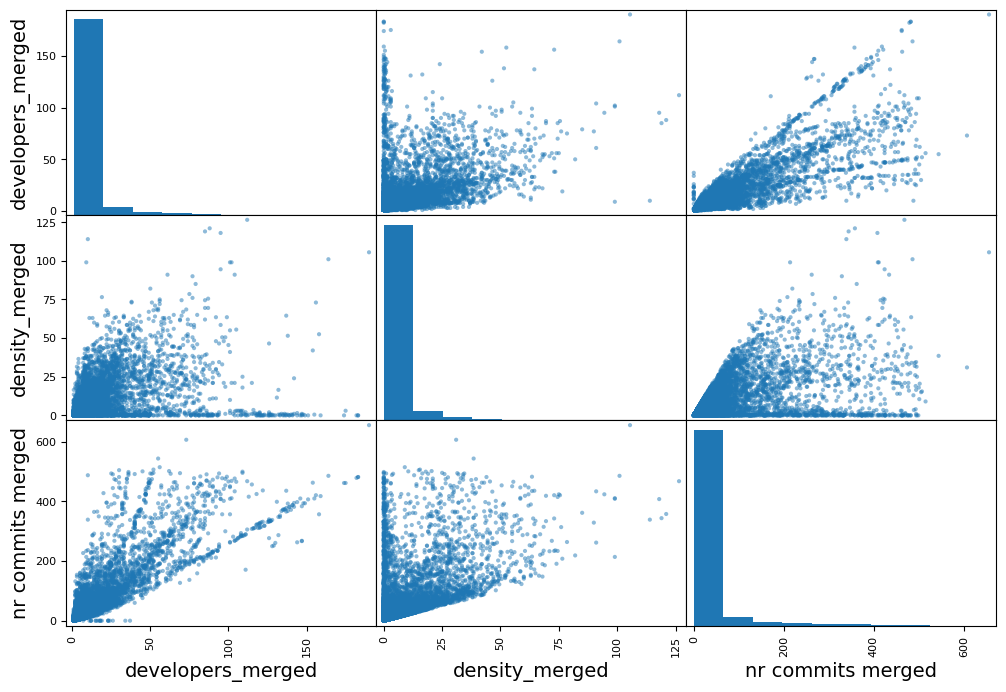

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["developers_merged", "density_merged",
              "nr commits merged"]
scatter_matrix(data[attributes], figsize=(12, 8))

In [34]:
corr_matrix = data.corr()
corr_matrix["modified files"].sort_values(ascending=False)

modified files       1.000000
added lines          0.395108
added files          0.212266
conflict             0.100076
renamed files        0.081408
delete               0.074506
fix                  0.063466
nr commits merged    0.051945
bug                  0.050148
remove               0.047464
messages_max         0.043376
nr files             0.042076
update               0.041816
refactor             0.038845
improve              0.036601
use                  0.035813
density_merged       0.035675
add                  0.031323
time                 0.030108
developers_merged    0.028553
deleted lines        0.022406
document             0.020998
change               0.019299
deleted files        0.013580
messages_mean        0.013375
messages_median      0.009855
feature              0.005627
messages_min        -0.027610
is pr               -0.095899
Name: modified files, dtype: float64

In [35]:
# Drop columns containing non-numeric values
num_data = data.select_dtypes(include='number')
median_values = num_data.median()

print("Median values:", median_values)

Median values: is pr                 1.000000
added lines          11.000000
deleted lines         2.000000
time                 36.000000
nr files              0.000000
added files           0.000000
deleted files         0.000000
renamed files         0.000000
modified files        1.000000
fix                   1.000000
bug                   0.000000
feature               0.000000
improve               0.000000
document              0.000000
refactor              0.000000
update                0.000000
add                   0.000000
remove                0.000000
use                   0.000000
delete                0.000000
change                0.000000
messages_min         46.000000
messages_max         87.000000
messages_mean        66.333333
messages_median      65.000000
conflict              0.000000
developers_merged     3.000000
density_merged        0.500000
nr commits merged     4.000000
dtype: float64


In [37]:
median_array = median_values.values
print (median_array)

[ 1.         11.          2.         36.          0.          0.
  0.          0.          1.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         46.         87.         66.33333333
 65.          0.          3.          0.5         4.        ]


# Training the Model


First of all, we split the atributes and the labels of the dataset.

In [42]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
encoded=data.apply(le.fit_transform)
encoded.head()

X=encoded[data.columns.drop('conflict')]
y=encoded['conflict']
X.head()

,is pr,added lines,deleted lines,time,nr files,added files,deleted files,renamed files,modified files,fix,...,use,delete,change,messages_min,messages_max,messages_mean,messages_median,developers_merged,density_merged,nr commits merged
0,1,5,0,23,0,0,0,0,4,0,...,0,0,0,20,64,433,33,0,0,5
1,0,970,963,371,3,7,55,2,139,1,...,0,0,0,31,116,1685,100,2,15,49
2,1,0,0,22,0,0,0,0,1,0,...,0,0,0,18,17,69,29,0,0,1
3,1,0,0,24,1,0,0,0,1,1,...,0,0,0,22,62,560,55,2,3,6
4,0,0,0,2,1,0,0,0,1,1,...,0,0,0,31,55,743,80,2,0,3


The resulting encoded values are split into sets:
1.   training
2.   testing

The order is training and than testing in order to check the corectness of the training.

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=12)

In the following section we normalize the values from the trained dataset in order to get a more scaled version of the values.

In [45]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [47]:
X_train[0]

array([ 0.52412867, -0.15556743, -0.17975599, -0.27809232, -0.169865  ,
       -0.21608772, -0.09504729, -0.08946572, -0.17878333, -0.35436439,
       -0.26637909, -0.19402037, -0.19277737, -0.24261963, -0.2229234 ,
       -0.32840089, -0.33382165, -0.29603608, -0.31049938, -0.18183419,
       -0.27299447,  0.0860942 , -0.59287191, -0.64926435, -0.38009462,
       -0.40598253, -0.39230034, -0.38443009])

I create an neural network with 1 input layer, 1 output layer and 1 hidden layer:

I use the 0.0001 learning rate in order to not have a big loss function.

In [71]:
inputModel_1 = Sequential()
inputModel_1.add(Dense(units=16, activation='relu'))
inputModel_1.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_1.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x1 = inputModel_1.fit(X_train, y_train, epochs=10)

Epoch 1/10
669/669 [==============================] - 2s 2ms/step - loss: 0.6256 - precision: 0.0983
Epoch 2/10
669/669 [==============================] - 1s 2ms/step - loss: 0.3600 - precision: 0.2530
Epoch 3/10
669/669 [==============================] - 1s 2ms/step - loss: 0.2413 - precision: 0.4606
Epoch 4/10
669/669 [==============================] - 2s 3ms/step - loss: 0.1835 - precision: 0.5647
Epoch 5/10
669/669 [==============================] - 2s 3ms/step - loss: 0.1547 - precision: 0.6504
Epoch 6/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1389 - precision: 0.7167
Epoch 7/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1291 - precision: 0.7345
Epoch 8/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1223 - precision: 0.7428
Epoch 9/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1173 - precision: 0.7422
Epoch 10/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1134 - precisi

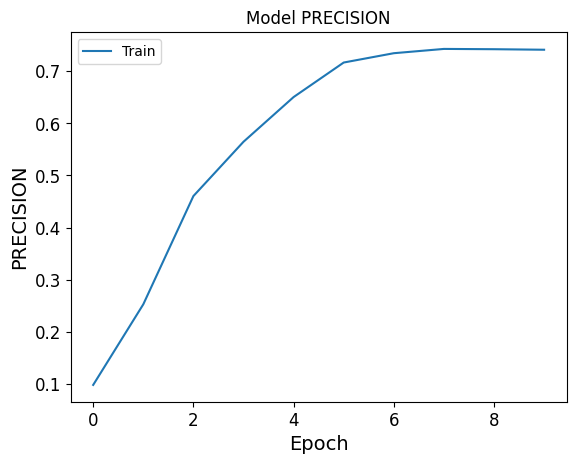

In [73]:
plt.plot(x1.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Transform the previos code from one layer with 16 neurons to one layer with 64 neurons. This results in geting better results.

In [76]:
inputModel_2 = Sequential()

inputModel_2.add(Dense(units=64, activation='relu'))

inputModel_2.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x2 = inputModel_2.fit(X_train, y_train, epochs=10)

Epoch 1/10
669/669 [==============================] - 8s 8ms/step - loss: 0.5065 - precision: 0.1069
Epoch 2/10
669/669 [==============================] - 2s 3ms/step - loss: 0.2142 - precision: 0.5870
Epoch 3/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1519 - precision: 0.7634
Epoch 4/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1301 - precision: 0.7425
Epoch 5/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1189 - precision: 0.7474
Epoch 6/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1117 - precision: 0.7306
Epoch 7/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1066 - precision: 0.7264
Epoch 8/10
669/669 [==============================] - 1s 2ms/step - loss: 0.1028 - precision: 0.7341
Epoch 9/10
669/669 [==============================] - 1s 2ms/step - loss: 0.0997 - precision: 0.7384
Epoch 10/10
669/669 [==============================] - 2s 3ms/step - loss: 0.0972 - precisi

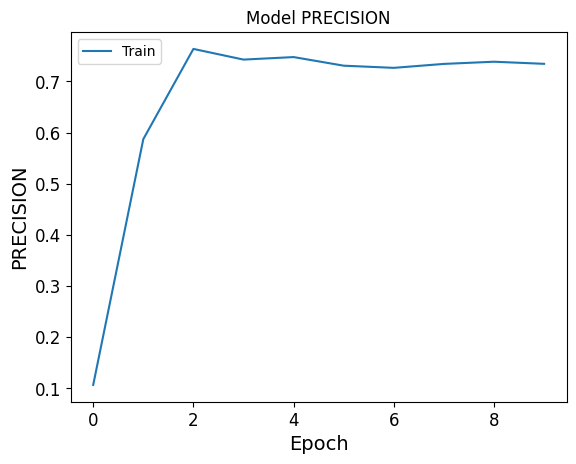

In [77]:
plt.plot(x2.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In this model I design it to have 1 input layer, 1 output layer and 4 hidden layes with 64 neurons each. This results in lowering the loss in each epoch.

In [79]:
inputModel_3 = Sequential()

inputModel_3.add(Dense(units=64, activation='relu'))
inputModel_3.add(Dense(units=64, activation='relu'))
inputModel_3.add(Dense(units=64, activation='relu'))
inputModel_3.add(Dense(units=64, activation='relu'))

inputModel_3.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_3.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x = inputModel_3.fit(X_train, y_train, epochs=10)

Epoch 1/10
669/669 [==============================] - 4s 3ms/step - loss: 0.2386 - precision: 0.1560
Epoch 2/10
669/669 [==============================] - 2s 4ms/step - loss: 0.1079 - precision: 0.7056
Epoch 3/10
669/669 [==============================] - 3s 4ms/step - loss: 0.0963 - precision: 0.6997
Epoch 4/10
669/669 [==============================] - 3s 4ms/step - loss: 0.0903 - precision: 0.7027
Epoch 5/10
669/669 [==============================] - 2s 3ms/step - loss: 0.0860 - precision: 0.7230
Epoch 6/10
669/669 [==============================] - 1s 2ms/step - loss: 0.0823 - precision: 0.7148
Epoch 7/10
669/669 [==============================] - 1s 2ms/step - loss: 0.0793 - precision: 0.7289
Epoch 8/10
669/669 [==============================] - 1s 2ms/step - loss: 0.0765 - precision: 0.7107
Epoch 9/10
669/669 [==============================] - 1s 2ms/step - loss: 0.0742 - precision: 0.7143
Epoch 10/10
669/669 [==============================] - 1s 2ms/step - loss: 0.0719 - precisi

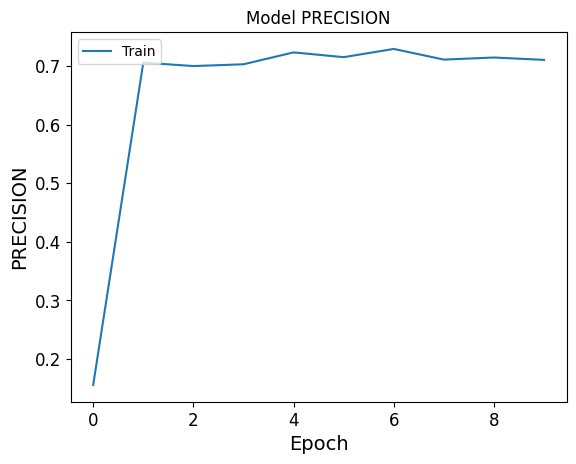

In [80]:
plt.plot(x.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Improved the neuranal network by using dropout layer. This method drops a part form the layer when not using it to prevent overfitting.
Is better for a new set of data and overall better, even if in this specific case the results seem not as good as the normal one, without overfitting avoidance.

In [82]:
from keras.layers import Dense, Dropout

inputModel_4 = Sequential()

inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))
inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))
inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))
inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))

inputModel_4.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_4.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x = inputModel_4.fit(X_train, y_train, epochs=10)

Epoch 1/10
669/669 [==============================] - 4s 3ms/step - loss: 0.2539 - precision: 0.4167
Epoch 2/10
669/669 [==============================] - 3s 4ms/step - loss: 0.1243 - precision: 0.6117
Epoch 3/10
669/669 [==============================] - 2s 3ms/step - loss: 0.1096 - precision: 0.6426
Epoch 4/10
669/669 [==============================] - 2s 2ms/step - loss: 0.1035 - precision: 0.6417
Epoch 5/10
669/669 [==============================] - 2s 2ms/step - loss: 0.0993 - precision: 0.6833
Epoch 6/10
669/669 [==============================] - 2s 3ms/step - loss: 0.0959 - precision: 0.6587
Epoch 7/10
669/669 [==============================] - 2s 3ms/step - loss: 0.0906 - precision: 0.6598
Epoch 8/10
669/669 [==============================] - 2s 3ms/step - loss: 0.0924 - precision: 0.6409
Epoch 9/10
669/669 [==============================] - 3s 4ms/step - loss: 0.0898 - precision: 0.6725
Epoch 10/10
669/669 [==============================] - 2s 3ms/step - loss: 0.0862 - precisi

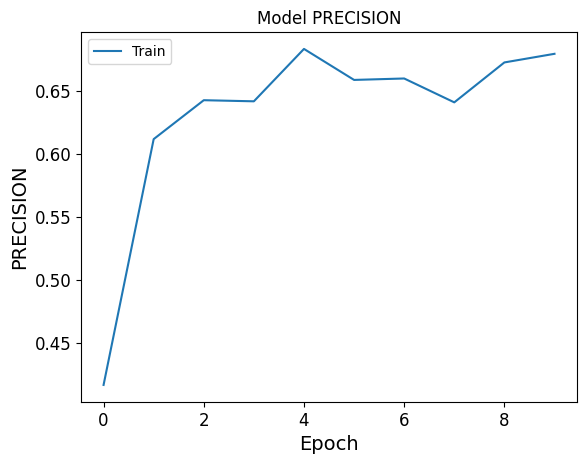

In [83]:
plt.plot(x.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Next I am going to comapre the versions on 50 epochs in order to compare the results.

In [84]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout

inputModel_4 = Sequential()

inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))
inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))
inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))
inputModel_4.add(Dense(units=64, activation='relu'))
inputModel_4.add(Dropout(0.1))

inputModel_4.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_4.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
x = inputModel_4.fit(X_train, y_train, epochs=50)

Epoch 1/50
669/669 [==============================] - 4s 3ms/step - loss: 0.2524 - precision: 0.1852
Epoch 2/50
669/669 [==============================] - 2s 2ms/step - loss: 0.1249 - precision: 0.5977
Epoch 3/50
669/669 [==============================] - 2s 3ms/step - loss: 0.1088 - precision: 0.6272
Epoch 4/50
669/669 [==============================] - 2s 3ms/step - loss: 0.1034 - precision: 0.6292
Epoch 5/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0986 - precision: 0.6667
Epoch 6/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0963 - precision: 0.6579
Epoch 7/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0928 - precision: 0.6611
Epoch 8/50
669/669 [==============================] - 3s 4ms/step - loss: 0.0896 - precision: 0.6630
Epoch 9/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0888 - precision: 0.6603
Epoch 10/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0862 - precisi

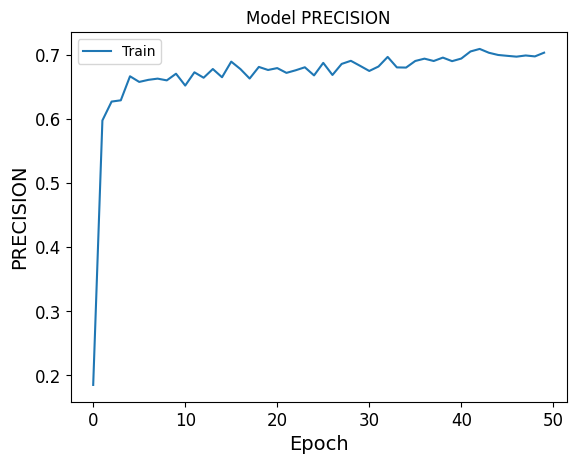

In [85]:
plt.plot(x.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Redesigned the hidden layer such that now the number of neurons decrease the further the layer is from the input. This is considered to be a good practice in order to train the model.

In [86]:
inputModel_5 = Sequential()

inputModel_5.add(Dense(units=64, activation='relu'))
inputModel_5.add(Dense(units=32, activation='relu'))
inputModel_5.add(Dense(units=16, activation='relu'))
inputModel_5.add(Dense(units=8, activation='relu'))

inputModel_5.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_5.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x = inputModel_5.fit(X_train, y_train, epochs=50)

Epoch 1/50
669/669 [==============================] - 3s 3ms/step - loss: 0.4140 - precision: 0.0970
Epoch 2/50
669/669 [==============================] - 2s 3ms/step - loss: 0.1353 - precision: 0.6908
Epoch 3/50
669/669 [==============================] - 1s 2ms/step - loss: 0.1110 - precision: 0.7378
Epoch 4/50
669/669 [==============================] - 1s 2ms/step - loss: 0.1009 - precision: 0.7265
Epoch 5/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0953 - precision: 0.7277
Epoch 6/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0907 - precision: 0.7295
Epoch 7/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0868 - precision: 0.7183
Epoch 8/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0837 - precision: 0.7302
Epoch 9/50
669/669 [==============================] - 3s 4ms/step - loss: 0.0812 - precision: 0.7266
Epoch 10/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0787 - precisi

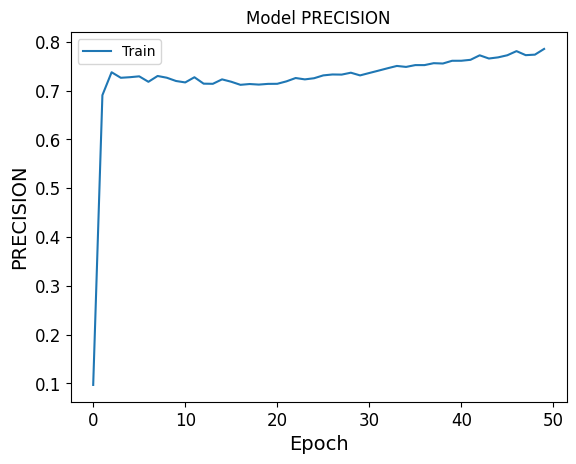

In [87]:
plt.plot(x.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

Increased the learning rate from 0.0001 to 0.001 in order to compare the 2 results. The conclusion is that by having the second learning rate closer to 1, the model will learn faster and have a better Precision. The idea is to not have it too big or too small and the second one behaves better in small number of epochs.

In [88]:
inputModel_6 = Sequential()

inputModel_6.add(Dense(units=64, activation='relu'))
inputModel_6.add(Dense(units=64, activation='relu'))
inputModel_6.add(Dense(units=64, activation='relu'))
inputModel_6.add(Dense(units=64, activation='relu'))

inputModel_6.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.001)
inputModel_6.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x = inputModel_6.fit(X_train, y_train, epochs=50)

Epoch 1/50
669/669 [==============================] - 4s 2ms/step - loss: 0.1150 - precision: 0.6372
Epoch 2/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0797 - precision: 0.6718
Epoch 3/50
669/669 [==============================] - 3s 4ms/step - loss: 0.0733 - precision: 0.6890
Epoch 4/50
669/669 [==============================] - 2s 4ms/step - loss: 0.0698 - precision: 0.7002
Epoch 5/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0677 - precision: 0.6995
Epoch 6/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0651 - precision: 0.7219
Epoch 7/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0641 - precision: 0.7240
Epoch 8/50
669/669 [==============================] - 2s 2ms/step - loss: 0.0606 - precision: 0.7482
Epoch 9/50
669/669 [==============================] - 2s 3ms/step - loss: 0.0603 - precision: 0.7559
Epoch 10/50
669/669 [==============================] - 3s 4ms/step - loss: 0.0593 - precisi

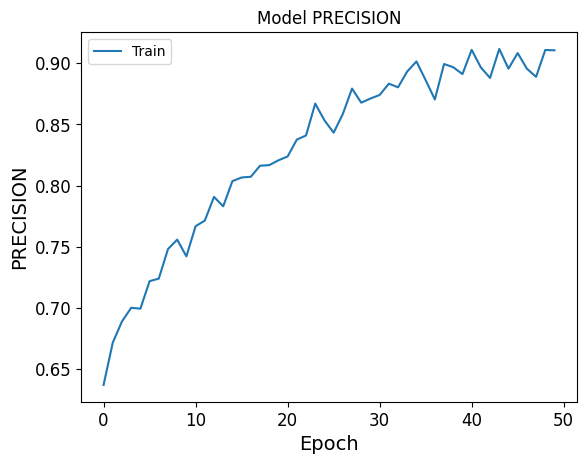

In [89]:
plt.plot(x.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

This time I changed the activation function to compare the results.

TAHN - is an activation funtion short for "Hyperbolic Tangent"

The formula for it is :

f(x) = (e^x - e^(-x)) / (e^x + e^(-x))

The output of the tanh activation function is Zero centered, hence we can easily map the output values as strongly negative, neutral, or strongly positive.

Usually used in hidden layers of a neural network as its values lie between -1 to; therefore, the mean for the hidden layer comes out to be 0 or very close to it. It helps in centering the data and makes learning for the next layer easier.


In [92]:
inputModel_7 = Sequential()

inputModel_7.add(Dense(units=64, activation='tanh'))
inputModel_7.add(Dense(units=32, activation='tanh'))
inputModel_7.add(Dense(units=16, activation='tanh'))
inputModel_7.add(Dense(units=8, activation='tanh'))

inputModel_7.add(Dense(1, activation='sigmoid'))
adam = keras.optimizers.Adam(learning_rate=0.0001)
inputModel_7.compile(loss='binary_crossentropy', optimizer=adam, metrics=[keras.metrics.Precision(name='precision')])

x = inputModel_7.fit(X_train, y_train, epochs=50)

Epoch 1/50
669/669 [==============================] - 3s 2ms/step - loss: 0.3588 - precision: 0.2248
Epoch 2/50
669/669 [==============================] - 1s 2ms/step - loss: 0.1542 - precision: 0.6364
Epoch 3/50
669/669 [==============================] - 2s 3ms/step - loss: 0.1200 - precision: 0.6644
Epoch 4/50
669/669 [==============================] - 2s 4ms/step - loss: 0.1063 - precision: 0.6804
Epoch 5/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0974 - precision: 0.6804
Epoch 6/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0909 - precision: 0.6931
Epoch 7/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0859 - precision: 0.6978
Epoch 8/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0822 - precision: 0.6944
Epoch 9/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0793 - precision: 0.6931
Epoch 10/50
669/669 [==============================] - 1s 2ms/step - loss: 0.0767 - precisi

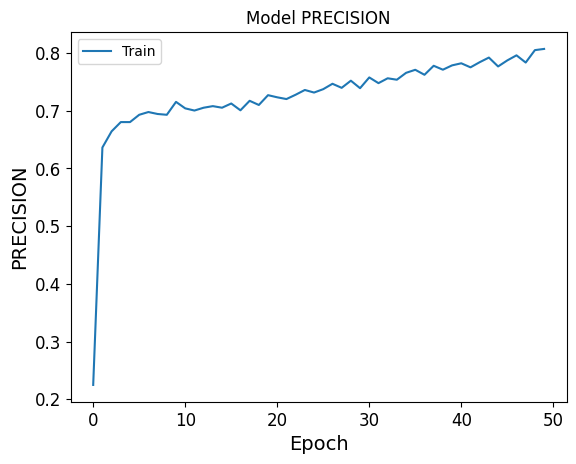

In [93]:
plt.plot(x.history['precision'])
plt.title('Model PRECISION')
plt.ylabel('PRECISION')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Conclusion

After trining I got to the conclusion that in order to get a good Precision, the learning rate should be around 0.001, and the design of the neuranal network sould be in a decreasing number of neurons on each layer from Input to Output. Also, training the model with more epochs the precison imporves.

I tested both Relu activation function and TANH and got to the conclusion that both are good and get to similar precision values for low number of layers.

ReLU is advantageous for its computational simplicity and effectiveness in mitigating the vanishing gradient problem, making it the default choice for many neural network architectures.

Tanh offers zero-centered outputs and can be more effective in specific cases, such as certain types of RNNs or networks dealing with centered data, but is prone to the vanishing gradient problem and requires more computational effort.

I prevented Overfitting by using Dropout and Early Stopping, both having a positive outcome for big neuranal networks.